# Chapter 15: Self-Attention and Transformers
Extraction of Named Entities with an Encoder Trained from Scratch

Programs from the book: [_Python for Natural Language Processing_](https://link.springer.com/book/9783031575488)

__Author__: Pierre Nugues

## Preliminaries

### Modules

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader

### Seeds
Making things reproduceable

In [2]:
random.seed(1234)
torch.manual_seed(1234)

### Constants

In [3]:
BATCH_SIZE = 128
EPOCHS = 50
dropout = 0.5
EMB_LARGE = True  # GloVe 50 or 100
d_model = 100
FREEZE_EMBS = False
# LR = 0.000075
LR = 0.0005

nhead = 5
num_layers = 4
dim_feedforward = 128

In [4]:
config = {'EPOCHS': EPOCHS,
          'num_layers': num_layers,
          'DROPOUT': dropout,
          'EMB_LARGE': EMB_LARGE,
          'FREEZE_EMBS': FREEZE_EMBS}

## Datasets

In [5]:
PATH = '../datasets/'

Install conlleval and download the dataset if not on your machine.

In [6]:
#!pip install conlleval

In [7]:
import conlleval

Uncomment and run this cell to download the CoNLL 2003 dataset

In [8]:
"""!wget https://data.deepai.org/conll2003.zip
!unzip -u conll2003.zip
!mkdir ../datasets/conll2003
!mv train.txt valid.txt test.txt ../datasets/conll2003
!rm conll2003.zip"""

'!wget https://data.deepai.org/conll2003.zip\n!unzip -u conll2003.zip\n!mkdir ../datasets/conll2003\n!mv train.txt valid.txt test.txt ../datasets/conll2003\n!rm conll2003.zip'

You may need to adjust the paths to load the datasets from your machine.

In [9]:
train_file = PATH + 'conll2003/train.txt'
val_file = PATH + 'conll2003/valid.txt'
test_file = PATH + 'conll2003/test.txt'

## Reading the files

### Loading the Embeddings
We will use GloVe embeddings and load them

In [10]:
if EMB_LARGE:
    embedding_file = PATH + 'embeddings/glove.6B.100d.txt'
    EMBEDDING_DIM = 100
else:
    embedding_file = PATH + 'embeddings/glove.6B.50d.txt'
    EMBEDDING_DIM = 50

In [11]:
def read_embeddings(file):
    """
    Return the embeddings in the from of a dictionary
    :param file:
    :return:
    """
    embeddings = {}
    glove = open(file, encoding='utf8')
    for line in glove:
        values = line.strip().split()
        word = values[0]
        vector = torch.FloatTensor(list(map(float, values[1:])))
        embeddings[word] = vector
    glove.close()
    return embeddings

In [12]:
embeddings_dict = read_embeddings(embedding_file)

In [13]:
embeddings_dict['table']

tensor([-0.6145,  0.8969,  0.5677,  0.3910, -0.2244,  0.4904,  0.1087,  0.2741,
        -0.2383, -0.5215,  0.7355, -0.3265,  0.5130,  0.3241, -0.4671,  0.6805,
        -0.2550, -0.0405, -0.5442, -1.0548, -0.4669,  0.2356,  0.3123, -0.3454,
         0.1479, -0.5375, -0.4322, -0.4872, -0.5102, -0.9051, -0.1792, -0.0184,
         0.0972, -0.3162,  0.7512,  0.9224, -0.4997,  0.1404, -0.2830, -0.9744,
        -0.0094, -0.6294,  0.1471, -0.9438,  0.0075,  0.1857, -0.9917,  0.0728,
        -0.1847, -0.5290,  0.3900, -0.4568, -0.2193,  1.3723, -0.2964, -2.2342,
        -0.3667,  0.0499,  0.6342,  0.5328, -0.5396,  0.3140, -0.4470, -0.3839,
         0.0667, -0.0217,  0.2056,  0.5946, -0.2489, -0.5279, -0.3761,  0.0771,
         0.7522, -0.2647, -0.0587,  0.6754, -0.1656, -0.4928, -0.2633, -0.2121,
         0.2432,  0.1701, -0.2926, -0.5009, -0.5664, -0.4038, -0.4845, -0.3254,
         0.7529,  0.0050, -0.3212,  0.2890, -0.0424,  0.6386, -0.2033, -0.4678,
        -0.1566,  0.2179,  1.4143,  0.40

### Loading the Corpus

In [14]:
def read_sentences(file):
    """
    Creates a list of sentences from the corpus
    Each sentence is a string
    :param file:
    :return:
    """
    f = open(file).read().strip()
    sentences = f.split('\n\n')
    return sentences

In [15]:
def split_rows(sentences, column_names):
    """
    Creates a list of sentence where each sentence is a list of lines
    Each line is a dictionary of columns
    :param sentences:
    :param column_names:
    :return:
    """
    new_sentences = []
    for sentence in sentences:
        rows = sentence.split('\n')
        sentence = [dict(zip(column_names, row.split())) for row in rows]
        new_sentences.append(sentence)
    return new_sentences

### Loading dictionaries

The CoNLL 2002 files have four columns: The wordform, `form`, its predicted part of speech, `ppos`, the predicted tag denoting the syntactic group also called the chunk tag, `pchunk`, and finally the named entity tag `ner`.

In [16]:
column_names = ['FORM', 'PPOS', 'PCHUNK', 'NER']

We load the corpus as a list of dictionaries

In [17]:
train_sentences = read_sentences(train_file)
train_dict = split_rows(train_sentences, column_names)

val_sentences = read_sentences(val_file)
val_dict = split_rows(val_sentences, column_names)

test_sentences = read_sentences(test_file)
test_dict = split_rows(test_sentences, column_names)

train_dict[1]

[{'FORM': 'EU', 'PPOS': 'NNP', 'PCHUNK': 'B-NP', 'NER': 'B-ORG'},
 {'FORM': 'rejects', 'PPOS': 'VBZ', 'PCHUNK': 'B-VP', 'NER': 'O'},
 {'FORM': 'German', 'PPOS': 'JJ', 'PCHUNK': 'B-NP', 'NER': 'B-MISC'},
 {'FORM': 'call', 'PPOS': 'NN', 'PCHUNK': 'I-NP', 'NER': 'O'},
 {'FORM': 'to', 'PPOS': 'TO', 'PCHUNK': 'B-VP', 'NER': 'O'},
 {'FORM': 'boycott', 'PPOS': 'VB', 'PCHUNK': 'I-VP', 'NER': 'O'},
 {'FORM': 'British', 'PPOS': 'JJ', 'PCHUNK': 'B-NP', 'NER': 'B-MISC'},
 {'FORM': 'lamb', 'PPOS': 'NN', 'PCHUNK': 'I-NP', 'NER': 'O'},
 {'FORM': '.', 'PPOS': '.', 'PCHUNK': 'O', 'NER': 'O'}]

### Function to build the two-way sequences
Two vectors: $\mathbf{x}$ and $\mathbf{y}$

In [18]:
def extract_cols(sent_dict, x='FORM', y='NER'):
    (input, target) = ([], [])
    for word in sent_dict:
        input += [word[x]]
        target += [word.get(y, None)]
    return input, target

In [19]:
train_cols = [extract_cols(sent_dict)
              for sent_dict in train_dict]
val_cols = [extract_cols(sent_dict)
            for sent_dict in val_dict]
test_cols = [extract_cols(sent_dict)
             for sent_dict in test_dict]

In [20]:
train_sent_words, train_sent_ner = zip(*train_cols)
val_sent_words, val_sent_ner = zip(*val_cols)
test_sent_words, test_sent_ner = zip(*test_cols)

In [21]:
train_sent_words[8131]

['He',
 'said',
 'Talbott',
 ',',
 'who',
 'was',
 'scheduled',
 'to',
 'return',
 'on',
 'Tuesday',
 ',',
 'would',
 'also',
 'to',
 'meet',
 'his',
 'Canadian',
 'counterpart',
 ',',
 'Gordon',
 'Smith',
 ',',
 'in',
 'Ottawa',
 'for',
 'talks',
 'that',
 'would',
 'include',
 'the',
 'situation',
 'in',
 'Haiti',
 '.']

In [22]:
train_sent_words = [list(map(str.lower, sentence))
                    for sentence in train_sent_words]
val_sent_words = [list(map(str.lower, sentence))
                  for sentence in val_sent_words]
test_sent_words = [list(map(str.lower, sentence))
                   for sentence in test_sent_words]

In [23]:
train_sent_words[1]

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']

In [24]:
train_sent_ner[1]

['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']

### Extracting the Unique Words and Parts of Speech

In [25]:
corpus_words = sorted(set([word
                           for sentence in train_sent_words
                           for word in sentence]))

In [26]:
ner_list = sorted(set([pos
                  for sentence in train_sent_ner
                  for pos in sentence]))

In [27]:
ner_list

['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']

In [28]:
NB_CLASSES = len(ner_list)
NB_CLASSES

9

### We create the dictionary
We add two words for the padding symbol and unknown words

In [29]:
embeddings_words = embeddings_dict.keys()
print('Words in GloVe:',  len(embeddings_dict.keys()))
vocabulary = sorted(list(set(corpus_words +
                             list(embeddings_words))))
vocab_size = len(vocabulary) + 2
print('# unique words in the vocabulary: embeddings and corpus:',
      vocab_size)

Words in GloVe: 400000
# unique words in the vocabulary: embeddings and corpus: 402597


### Function to convert the words or parts of speech to indices

In [30]:
# We start at one to make provision for the padding symbol 0
# in RNN and LSTMs and 1 for the unknown words
idx2word = dict(enumerate(vocabulary, start=2))
idx2ner = dict(enumerate(ner_list, start=1))
word2idx = {v: k for k, v in idx2word.items()}
ner2idx = {v: k for k, v in idx2ner.items()}
print('word index:', list(word2idx.items())[:10])
print('NER index:', list(ner2idx.items())[:10])

word index: [('!', 2), ('!!', 3), ('!!!', 4), ('!!!!', 5), ('!!!!!', 6), ('!?', 7), ('!?!', 8), ('"', 9), ('#', 10), ('##', 11)]
NER index: [('B-LOC', 1), ('B-MISC', 2), ('B-ORG', 3), ('B-PER', 4), ('I-LOC', 5), ('I-MISC', 6), ('I-ORG', 7), ('I-PER', 8), ('O', 9)]


In [31]:
def to_index(X: list[list[str]],
             word2idx: dict[str, int],
             unk: int = 1) -> torch.LongTensor:
    """
    Convert the word lists (or POS lists) to indexes
    :param X: List of word (or POS) lists
    :param idx: word to idx dictionary
    :return:
    """
    X_idx = []
    for x in X:
        # We map the unknown words to one
        x_idx = torch.LongTensor(
            list(map(lambda x:
                     word2idx.get(x, unk), x)))
        X_idx += [x_idx]
    return X_idx

### We create the indexes

In [32]:
# We create the parallel sequences of indexes
X_train_idx = to_index(train_sent_words, word2idx)
Y_train_idx = to_index(train_sent_ner, ner2idx)

X_val_idx = to_index(val_sent_words, word2idx)
Y_val_idx = to_index(val_sent_ner, ner2idx)

X_test_idx = to_index(test_sent_words, word2idx)
Y_test_idx = to_index(test_sent_ner, ner2idx)

print('First sentences, word indices', X_train_idx[:3])
print('First sentences, NER indices', Y_train_idx[:3])

First sentences, word indices [tensor([935]), tensor([142143, 307143, 161836,  91321, 363368,  83766,  85852, 218260,    936]), tensor([284434,  79019])]
First sentences, NER indices [tensor([9]), tensor([3, 9, 2, 9, 9, 9, 2, 9, 9]), tensor([4, 8])]


### We pad the sentences
We keep the traditional order to avoid changing the dataloader

In [33]:
X_train = pad_sequence(X_train_idx, batch_first=True)
Y_train = pad_sequence(Y_train_idx, batch_first=True)

X_val = pad_sequence(X_val_idx, batch_first=True)
Y_val = pad_sequence(Y_val_idx, batch_first=True)

X_test = pad_sequence(X_test_idx, batch_first=True)
Y_test = pad_sequence(Y_test_idx, batch_first=True)

In [34]:
Y_train

tensor([[9, 0, 0,  ..., 0, 0, 0],
        [3, 9, 2,  ..., 0, 0, 0],
        [4, 8, 0,  ..., 0, 0, 0],
        ...,
        [3, 9, 3,  ..., 0, 0, 0],
        [9, 9, 0,  ..., 0, 0, 0],
        [3, 9, 3,  ..., 0, 0, 0]])

In [35]:
X_train_idx[8131:8134]

[tensor([176967, 318004, 354554,    517, 389433, 386048, 322755, 363368, 309292,
         271939, 369376,    517, 392694,  53898, 363368, 241803, 181212,  92077,
         111905,    517, 166368, 337765,    517, 190291, 274846, 153033, 354663,
         359644, 392694, 190648, 359698, 335549, 190291, 173081,    936]),
 tensor([935]),
 tensor([371668, 245894, 182065, 236839, 325743, 344614, 369376,    679, 365911,
            936])]

In [36]:
pad_sequence(X_train_idx[8131:8134], batch_first=True)

tensor([[176967, 318004, 354554,    517, 389433, 386048, 322755, 363368, 309292,
         271939, 369376,    517, 392694,  53898, 363368, 241803, 181212,  92077,
         111905,    517, 166368, 337765,    517, 190291, 274846, 153033, 354663,
         359644, 392694, 190648, 359698, 335549, 190291, 173081,    936],
        [   935,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0],
        [371668, 245894, 182065, 236839, 325743, 344614, 369376,    679, 365911,
            936,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0]])

In [37]:
pad_sequence(X_train_idx[8131:8134])

tensor([[176967,    935, 371668],
        [318004,      0, 245894],
        [354554,      0, 182065],
        [   517,      0, 236839],
        [389433,      0, 325743],
        [386048,      0, 344614],
        [322755,      0, 369376],
        [363368,      0,    679],
        [309292,      0, 365911],
        [271939,      0,    936],
        [369376,      0,      0],
        [   517,      0,      0],
        [392694,      0,      0],
        [ 53898,      0,      0],
        [363368,      0,      0],
        [241803,      0,      0],
        [181212,      0,      0],
        [ 92077,      0,      0],
        [111905,      0,      0],
        [   517,      0,      0],
        [166368,      0,      0],
        [337765,      0,      0],
        [   517,      0,      0],
        [190291,      0,      0],
        [274846,      0,      0],
        [153033,      0,      0],
        [354663,      0,      0],
        [359644,      0,      0],
        [392694,      0,      0],
        [19064

## Embedding matrix
0 is the padding symbol and index one is a unknown word

In [38]:
embedding_table = torch.randn(
    (len(vocabulary) + 2, d_model))/10
# embedding_table = torch.rand(
#    (len(vocabulary) + 2, EMBEDDING_DIM))/10 - 0.05  # range: -0.05, 0.05,

In [39]:
embedding_table.size()

torch.Size([402597, 100])

In [40]:
for word in vocabulary:
    if word in embeddings_dict:
        # If the words are in the embeddings, we fill them with a value
        embedding_table[word2idx[word]] = embeddings_dict[word]

Embedding of table

In [41]:
embedding_table[word2idx['table']]

tensor([-0.6145,  0.8969,  0.5677,  0.3910, -0.2244,  0.4904,  0.1087,  0.2741,
        -0.2383, -0.5215,  0.7355, -0.3265,  0.5130,  0.3241, -0.4671,  0.6805,
        -0.2550, -0.0405, -0.5442, -1.0548, -0.4669,  0.2356,  0.3123, -0.3454,
         0.1479, -0.5375, -0.4322, -0.4872, -0.5102, -0.9051, -0.1792, -0.0184,
         0.0972, -0.3162,  0.7512,  0.9224, -0.4997,  0.1404, -0.2830, -0.9744,
        -0.0094, -0.6294,  0.1471, -0.9438,  0.0075,  0.1857, -0.9917,  0.0728,
        -0.1847, -0.5290,  0.3900, -0.4568, -0.2193,  1.3723, -0.2964, -2.2342,
        -0.3667,  0.0499,  0.6342,  0.5328, -0.5396,  0.3140, -0.4470, -0.3839,
         0.0667, -0.0217,  0.2056,  0.5946, -0.2489, -0.5279, -0.3761,  0.0771,
         0.7522, -0.2647, -0.0587,  0.6754, -0.1656, -0.4928, -0.2633, -0.2121,
         0.2432,  0.1701, -0.2926, -0.5009, -0.5664, -0.4038, -0.4845, -0.3254,
         0.7529,  0.0050, -0.3212,  0.2890, -0.0424,  0.6386, -0.2033, -0.4678,
        -0.1566,  0.2179,  1.4143,  0.40

Embedding of the padding symbol, idx 0, random numbers

In [42]:
embedding_table[0]

tensor([-0.0112, -0.0497,  0.0163, -0.0882,  0.0054,  0.0668, -0.0060, -0.0467,
        -0.0215,  0.0884, -0.0758, -0.0369, -0.0342, -0.1402,  0.0321, -0.1022,
         0.0799, -0.0092, -0.0705, -0.1602,  0.0289,  0.0490, -0.0385, -0.0712,
        -0.0171, -0.1459,  0.0221,  0.0246, -0.1325,  0.0697, -0.0663,  0.1216,
        -0.1495,  0.0881, -0.1179, -0.0934, -0.0568, -0.0277, -0.2183,  0.0367,
         0.0938,  0.0008, -0.0314, -0.1157,  0.1841, -0.1017,  0.1219,  0.0160,
         0.1598, -0.0047, -0.1527, -0.2014, -0.1517,  0.0388, -0.1185,  0.0690,
         0.1323,  0.1817,  0.0681,  0.0724,  0.0032, -0.1659, -0.1877,  0.0737,
         0.0926,  0.0925,  0.0183, -0.0074,  0.0315, -0.1037,  0.0210,  0.0614,
         0.0063, -0.0330, -0.1797,  0.0873,  0.0767, -0.0114, -0.0943,  0.0754,
         0.0141, -0.0694, -0.0616, -0.0730,  0.0431,  0.0286, -0.0248,  0.0204,
         0.0852, -0.1410, -0.0107, -0.0802,  0.0277,  0.2560, -0.1695,  0.0189,
         0.0739,  0.1590, -0.0195, -0.02

The size of the matrix

In [43]:
embedding_table.size()

torch.Size([402597, 100])

## Network Architecture

In [44]:
class Embedding(nn.Module):
    def __init__(self,
                 vocab_size,
                 d_model,
                 dropout=0.1,
                 max_len=500):
        super().__init__()
        self.d_model = d_model
        self.input_embedding = nn.Embedding(vocab_size, d_model)
        pe = self.pos_encoding(max_len, d_model)
        self.pos_embedding = nn.Embedding.from_pretrained(
            pe, freeze=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, X):
        pos_mat = torch.arange(X.size(dim=-1))
        X = self.input_embedding(X) * math.sqrt(self.d_model)
        X += self.pos_embedding(pos_mat)
        return self.dropout(X)

    def pos_encoding(self, max_len, d_model):
        dividend = torch.arange(max_len).unsqueeze(0).T
        divisor = torch.pow(10000.0,
                            torch.arange(0, d_model, 2)/d_model)
        angles = dividend / divisor
        pe = torch.zeros((max_len, d_model))
        pe[:, 0::2] = torch.sin(angles)
        pe[:, 1::2] = torch.cos(angles)
        return pe

In [45]:
class Model(nn.Module):
    def __init__(self,
                 embeddings,
                 d_model,
                 nhead,
                 num_layers,
                 nbr_classes,
                 dim_feedforward=2048,
                 dropout=0.1):
        super().__init__()
        self.embeddings = embeddings
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model,
            nhead,
            batch_first=True,
            dropout=dropout,
            dim_feedforward=dim_feedforward)
        self.encoder = nn.TransformerEncoder(
            self.encoder_layer, num_layers)
        self.fc = nn.Linear(d_model, nbr_classes)

    def forward(self, X):
        padding_mask = (X == 0)
        X = self.embeddings(X)
        X = self.encoder(
            X, src_key_padding_mask=padding_mask)
        return self.fc(X)

We create the embedding table

In [46]:
embedding = Embedding(vocab_size, d_model, dropout=dropout)

In [47]:
embedding.input_embedding.weight = nn.Parameter(embedding_table)

In [48]:
model = Model(embedding,
              d_model,
              nhead,
              num_layers,
              NB_CLASSES + 1,
              dim_feedforward=dim_feedforward,
              dropout=dropout)

/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [49]:
tt = torch.LongTensor([[371668, 245894, 182065, 236839, 325743, 344614, 369376],
                       [245894, 371668, 182065, 236839, 325743, 344614, 369376]])

In [50]:
model.eval()

Model(
  (embeddings): Embedding(
    (input_embedding): Embedding(402597, 100)
    (pos_embedding): Embedding(500, 100)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
    )
    (linear1): Linear(in_features=100, out_features=128, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (linear2): Linear(in_features=128, out_features=100, bias=True)
    (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.5, inplace=False)
    (dropout2): Dropout(p=0.5, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=

In [51]:
Y = model(tt)
Y

tensor([[[ 0.0868, -0.1844, -0.6645, -0.4558, -0.7237, -0.5885, -0.0501,
           0.0168,  0.4181, -0.6112],
         [ 0.5107, -0.8600,  0.0356, -0.6797, -0.4875,  0.4446,  0.4987,
          -0.0962,  0.1016, -0.6308],
         [-0.6386, -0.4005, -0.0806,  0.1498, -0.3325, -0.2327,  0.3884,
           0.6235,  0.5851, -0.1949],
         [ 0.2550,  0.1719, -0.5210, -0.4140, -0.7340, -0.3835,  0.1289,
           0.6769,  0.7852, -0.2913],
         [-0.3051,  0.0929, -0.4410, -0.3048, -0.1174, -0.1868, -0.2033,
           0.2880, -0.2011, -0.1127],
         [ 0.3391,  0.1393, -0.6261, -0.7418,  0.3060,  0.3583,  0.3795,
          -0.1162,  0.1328, -0.2875],
         [ 0.0015,  0.1672, -0.5817, -0.6465, -0.4192,  0.2476, -0.5080,
           0.3122,  0.3554, -1.1629]],

        [[ 0.5098, -0.8552,  0.0296, -0.6970, -0.4621,  0.4393,  0.4799,
          -0.0782,  0.1239, -0.6417],
         [ 0.0811, -0.1758, -0.6553, -0.4462, -0.7399, -0.5910, -0.0452,
           0.0024,  0.4187, -0.6169],

In [52]:
Y[:, 0, :]

tensor([[ 0.0868, -0.1844, -0.6645, -0.4558, -0.7237, -0.5885, -0.0501,  0.0168,
          0.4181, -0.6112],
        [ 0.5098, -0.8552,  0.0296, -0.6970, -0.4621,  0.4393,  0.4799, -0.0782,
          0.1239, -0.6417]], grad_fn=<SliceBackward0>)

In [53]:
model.embeddings.input_embedding.weight[0]

tensor([-0.0112, -0.0497,  0.0163, -0.0882,  0.0054,  0.0668, -0.0060, -0.0467,
        -0.0215,  0.0884, -0.0758, -0.0369, -0.0342, -0.1402,  0.0321, -0.1022,
         0.0799, -0.0092, -0.0705, -0.1602,  0.0289,  0.0490, -0.0385, -0.0712,
        -0.0171, -0.1459,  0.0221,  0.0246, -0.1325,  0.0697, -0.0663,  0.1216,
        -0.1495,  0.0881, -0.1179, -0.0934, -0.0568, -0.0277, -0.2183,  0.0367,
         0.0938,  0.0008, -0.0314, -0.1157,  0.1841, -0.1017,  0.1219,  0.0160,
         0.1598, -0.0047, -0.1527, -0.2014, -0.1517,  0.0388, -0.1185,  0.0690,
         0.1323,  0.1817,  0.0681,  0.0724,  0.0032, -0.1659, -0.1877,  0.0737,
         0.0926,  0.0925,  0.0183, -0.0074,  0.0315, -0.1037,  0.0210,  0.0614,
         0.0063, -0.0330, -0.1797,  0.0873,  0.0767, -0.0114, -0.0943,  0.0754,
         0.0141, -0.0694, -0.0616, -0.0730,  0.0431,  0.0286, -0.0248,  0.0204,
         0.0852, -0.1410, -0.0107, -0.0802,  0.0277,  0.2560, -0.1695,  0.0189,
         0.0739,  0.1590, -0.0195, -0.02

In [54]:
model.embeddings.input_embedding.weight[1]

tensor([ 0.1320,  0.1600, -0.1079, -0.0340, -0.0678, -0.0126, -0.1677,  0.1207,
         0.0572,  0.0065, -0.0023,  0.0888,  0.0957, -0.0551,  0.2662,  0.2148,
        -0.0855, -0.0721,  0.1375,  0.0999,  0.0147, -0.0905, -0.0359,  0.1637,
         0.0690, -0.0584,  0.0908,  0.0485, -0.0263, -0.0543, -0.1641,  0.0929,
         0.1291,  0.0261, -0.0586, -0.1511, -0.2015,  0.0696, -0.0668, -0.0842,
         0.0529, -0.0545,  0.0810,  0.1123, -0.0613,  0.0223,  0.0459, -0.1703,
        -0.1278, -0.0743,  0.0971,  0.0355, -0.1517, -0.0357,  0.0945, -0.2172,
        -0.0804, -0.0453, -0.0222, -0.2090, -0.0177, -0.0898, -0.0983,  0.0756,
         0.0347,  0.0286, -0.0050,  0.0622, -0.1922, -0.1318,  0.1229,  0.0702,
        -0.0017, -0.0283, -0.0645, -0.0020,  0.0112, -0.0660, -0.0624, -0.0742,
         0.0342, -0.0287, -0.0673,  0.0884,  0.0721,  0.0221, -0.0274,  0.0861,
        -0.0061,  0.2107, -0.0993,  0.1408, -0.0795,  0.0614, -0.0273,  0.1656,
         0.1394,  0.0606,  0.0221, -0.08

In [55]:
model.embeddings.input_embedding.weight[10]

tensor([-0.6610, -0.0730,  0.9238, -0.0718,  1.0945,  0.1950,  0.4511, -0.3000,
        -0.4472, -0.1123,  1.3161, -0.3353,  0.0174, -0.1921,  0.1070,  0.3756,
         0.8463,  0.6620,  0.0450,  1.2140,  1.0393,  0.1577,  0.2752,  0.2246,
         0.5684,  0.2948,  1.2411, -0.0132,  1.0577,  0.0702, -0.1073,  0.4655,
         0.1687,  0.4505, -0.8855,  0.8223, -0.8329, -0.4462,  0.3347, -0.1175,
         0.2707, -0.2720, -0.2407,  0.1367, -0.0264, -0.2577, -0.1063,  0.3439,
         0.1640, -0.5715, -0.4084,  0.3890, -0.2821,  0.5552, -0.1509, -2.1747,
        -0.1657, -0.0418,  0.5616,  0.3790, -0.2015, -0.3954, -1.0113,  0.3326,
         0.9866, -0.1064, -0.6649,  0.5415,  0.3460,  0.6742, -0.6132,  0.0484,
        -0.6179,  1.9346,  0.2311,  0.7830,  0.4083,  0.0910, -0.3833, -1.0883,
        -0.3142, -0.1635, -0.3189, -0.5546,  0.4838, -0.2736,  0.0746, -1.4758,
        -0.1847,  1.1626, -0.6364,  0.7753,  0.1519,  1.0319, -0.8456, -0.2495,
        -0.3340, -0.2256,  0.8148, -0.44

In [56]:
model.embeddings.pos_embedding.weight[10]

tensor([-0.5440, -0.8391,  0.8944, -0.4472,  0.5933,  0.8050, -0.5045,  0.8634,
        -0.9973,  0.0738, -0.7443, -0.6679, -0.1689, -0.9856,  0.3777, -0.9259,
         0.7518, -0.6594,  0.9445, -0.3285,  0.9999, -0.0141,  0.9683,  0.2499,
         0.8896,  0.4567,  0.7907,  0.6122,  0.6879,  0.7258,  0.5899,  0.8075,
         0.5010,  0.8654,  0.4228,  0.9062,  0.3552,  0.9348,  0.2974,  0.9547,
         0.2486,  0.9686,  0.2074,  0.9783,  0.1729,  0.9849,  0.1440,  0.9896,
         0.1199,  0.9928,  0.0998,  0.9950,  0.0831,  0.9965,  0.0691,  0.9976,
         0.0575,  0.9983,  0.0478,  0.9989,  0.0398,  0.9992,  0.0331,  0.9995,
         0.0275,  0.9996,  0.0229,  0.9997,  0.0191,  0.9998,  0.0158,  0.9999,
         0.0132,  0.9999,  0.0110,  0.9999,  0.0091,  1.0000,  0.0076,  1.0000,
         0.0063,  1.0000,  0.0052,  1.0000,  0.0044,  1.0000,  0.0036,  1.0000,
         0.0030,  1.0000,  0.0025,  1.0000,  0.0021,  1.0000,  0.0017,  1.0000,
         0.0014,  1.0000,  0.0012,  1.00

In [57]:
X = X_train[:32]

In [58]:
e = embedding(X)

In [59]:
model(X).size()

torch.Size([32, 113, 10])

The loss `loss_fn` and optimizer `optimizer`.


In [60]:
# Write your code
loss_fn = nn.CrossEntropyLoss(ignore_index=0)    # cross entropy loss
# optimizer = torch.optim.NAdam(model.parameters(), lr=LR)
optimizer = torch.optim.AdamW(model.parameters())
# optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.5)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=LR)

## Data Loaders

In [61]:
train_dataset = TensorDataset(X_train, Y_train)
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(X_val, Y_val)
val_dataloader = DataLoader(
    val_dataset, batch_size=2048, shuffle=False)

test_dataset = TensorDataset(X_test, Y_test)
test_dataloader = DataLoader(
    test_dataset, batch_size=2048, shuffle=False)

## A Few Experiments

### Flattening the tensors

In [62]:
Y_train.size()

torch.Size([14987, 113])

In [63]:
Y_train.view(-1)[:1000]

tensor([9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 9, 2, 9, 9, 9, 2,
        9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [64]:
Y_train.reshape(-1).size()

torch.Size([1693531])

### Applying the Model

We apply the model to the whole training set by batch

In [65]:
def batch_inference(model, dataloader):
    with torch.no_grad():
        y_pred = []
        for X_batch, _ in dataloader:
            y_pred += [model(X_batch)]
    return torch.vstack(y_pred)

In [66]:
X_train[:3]

tensor([[   935,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,    

## Training the Model

We create a dictionary to store the accuracy and the loss. We compute them in the training loop. We exclude the the padding symbols from your counts. To do this, we use a multiplicative mask with the terms Y_train > 0 or Y_val > 0. This is not critical though as we will evaluate the final results with another script. 

In [67]:
def evaluate(model,
             loss_fn,
             dataloader) -> tuple[float, float]:
    model.eval()
    with torch.no_grad():
        y_pred = []
        y = []
        for X_batch, Y_batch in dataloader:
            y_pred += [model(X_batch)]
            y += [Y_batch]
        Y_pred = torch.vstack(y_pred)
        Y = torch.vstack(y)
        loss = loss_fn(
            Y_pred.reshape(
                -1,
                Y_pred.size(dim=-1)),
            Y.reshape(-1))
        acc = torch.sum(
            torch.mul(
                torch.argmax(
                    Y_pred, dim=-1) == Y,
                Y > 0))
        return loss.item(), (acc/torch.sum(Y > 0)).item()

In [68]:
history = {}
history['accuracy'] = []
history['loss'] = []
history['val_accuracy'] = []
history['val_loss'] = []

We fit the model

In [69]:
for epoch in range(EPOCHS):
    train_loss = 0
    train_accuracy = 0
    loss = 0
    acc = 0
    batch_cnt = 0
    model.train()
    for X_batch, Y_batch in tqdm(train_dataloader):
        batch_cnt += 1
        Y_batch_pred = model(X_batch)
        loss = loss_fn(
            Y_batch_pred.reshape(
                -1,
                Y_batch_pred.size(dim=-1)),
            Y_batch.reshape(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        with torch.no_grad():
            train_accuracy += torch.sum(
                torch.mul(
                    torch.argmax(
                        Y_batch_pred, dim=-1) == Y_batch,
                    Y_batch > 0))

    model.eval()
    with torch.no_grad():
        history['accuracy'] += [train_accuracy.item()/torch.sum(Y_train > 0)]
        history['loss'] += [train_loss/batch_cnt]
        val_loss, val_acc = evaluate(model, loss_fn, val_dataloader)
        history['val_loss'] += [val_loss]
        history['val_accuracy'] += [val_acc]
        print('accuracy:', history['accuracy'])
        print('val_accuracy:', history['val_accuracy'])

100%|██████████| 118/118 [01:02<00:00,  1.90it/s]


accuracy: [tensor(0.8301)]
val_accuracy: [0.8755670785903931]


100%|██████████| 118/118 [01:02<00:00,  1.89it/s]


accuracy: [tensor(0.8301), tensor(0.8632)]
val_accuracy: [0.8755670785903931, 0.910756528377533]


100%|██████████| 118/118 [00:59<00:00,  1.99it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695]


100%|██████████| 118/118 [00:58<00:00,  2.01it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972]


100%|██████████| 118/118 [00:58<00:00,  2.01it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057]


100%|██████████| 118/118 [00:58<00:00,  2.00it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171]


100%|██████████| 118/118 [01:00<00:00,  1.95it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853]


100%|██████████| 118/118 [00:58<00:00,  2.01it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698]


100%|██████████| 118/118 [00:58<00:00,  2.00it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438]


100%|██████████| 118/118 [00:58<00:00,  2.00it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566]


100%|██████████| 118/118 [00:59<00:00,  1.99it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566, 0.9478071928024292]


100%|██████████| 118/118 [01:00<00:00,  1.96it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566, 0.9478071928024292, 0.9491062164306641]


100%|██████████| 118/118 [00:58<00:00,  2.01it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345), tensor(0.9378)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566, 0.9478071928024292, 0.9491062164306641, 0.9505021572113037]


100%|██████████| 118/118 [00:58<00:00,  2.00it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345), tensor(0.9378), tensor(0.9400)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566, 0.9478071928024292, 0.9491062164306641, 0.9505021572113037, 0.9503082633018494]


100%|██████████| 118/118 [00:58<00:00,  2.00it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345), tensor(0.9378), tensor(0.9400), tensor(0.9423)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566, 0.9478071928024292, 0.9491062164306641, 0.9505021572113037, 0.9503082633018494, 0.9521501660346985]


100%|██████████| 118/118 [00:59<00:00,  1.99it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345), tensor(0.9378), tensor(0.9400), tensor(0.9423), tensor(0.9446)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566, 0.9478071928024292, 0.9491062164306641, 0.9505021572113037, 0.9503082633018494, 0.9521501660346985, 0.952324628829956]


100%|██████████| 118/118 [01:00<00:00,  1.95it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345), tensor(0.9378), tensor(0.9400), tensor(0.9423), tensor(0.9446), tensor(0.9470)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566, 0.9478071928024292, 0.9491062164306641, 0.9505021572113037, 0.9503082633018494, 0.9521501660346985, 0.952324628829956, 0.9534685611724854]


100%|██████████| 118/118 [00:59<00:00,  1.99it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345), tensor(0.9378), tensor(0.9400), tensor(0.9423), tensor(0.9446), tensor(0.9470), tensor(0.9486)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566, 0.9478071928024292, 0.9491062164306641, 0.9505021572113037, 0.9503082633018494, 0.9521501660346985, 0.952324628829956, 0.9534685611724854, 0.9529062509536743]


100%|██████████| 118/118 [00:58<00:00,  2.01it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345), tensor(0.9378), tensor(0.9400), tensor(0.9423), tensor(0.9446), tensor(0.9470), tensor(0.9486), tensor(0.9500)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566, 0.9478071928024292, 0.9491062164306641, 0.9505021572113037, 0.9503082633018494, 0.9521501660346985, 0.952324628829956, 0.9534685611724854, 0.9529062509536743, 0.9540695548057556]


100%|██████████| 118/118 [00:58<00:00,  2.00it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345), tensor(0.9378), tensor(0.9400), tensor(0.9423), tensor(0.9446), tensor(0.9470), tensor(0.9486), tensor(0.9500), tensor(0.9516)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566, 0.9478071928024292, 0.9491062164306641, 0.9505021572113037, 0.9503082633018494, 0.9521501660346985, 0.952324628829956, 0.9534685611724854, 0.9529062509536743, 0.9540695548057556, 0.9524215459823608]


100%|██████████| 118/118 [00:59<00:00,  1.98it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345), tensor(0.9378), tensor(0.9400), tensor(0.9423), tensor(0.9446), tensor(0.9470), tensor(0.9486), tensor(0.9500), tensor(0.9516), tensor(0.9525)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566, 0.9478071928024292, 0.9491062164306641, 0.9505021572113037, 0.9503082633018494, 0.9521501660346985, 0.952324628829956, 0.9534685611724854, 0.9529062509536743, 0.9540695548057556, 0.9524215459823608, 0.9537011981010437]


100%|██████████| 118/118 [01:01<00:00,  1.93it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345), tensor(0.9378), tensor(0.9400), tensor(0.9423), tensor(0.9446), tensor(0.9470), tensor(0.9486), tensor(0.9500), tensor(0.9516), tensor(0.9525), tensor(0.9547)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566, 0.9478071928024292, 0.9491062164306641, 0.9505021572113037, 0.9503082633018494, 0.9521501660346985, 0.952324628829956, 0.9534685611724854, 0.9529062509536743, 0.9540695548057556, 0.9524215459823608, 0.9537011981010437, 0.9551553130149841]


100%|██████████| 118/118 [01:00<00:00,  1.94it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345), tensor(0.9378), tensor(0.9400), tensor(0.9423), tensor(0.9446), tensor(0.9470), tensor(0.9486), tensor(0.9500), tensor(0.9516), tensor(0.9525), tensor(0.9547), tensor(0.9555)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566, 0.9478071928024292, 0.9491062164306641, 0.9505021572113037, 0.9503082633018494, 0.9521501660346985, 0.952324628829956, 0.9534685611724854, 0.9529062509536743, 0.9540695548057556, 0.9524215459823608, 0.9537011981010437, 0.9551553130149841, 0.9549614191055298]


100%|██████████| 118/118 [01:00<00:00,  1.94it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345), tensor(0.9378), tensor(0.9400), tensor(0.9423), tensor(0.9446), tensor(0.9470), tensor(0.9486), tensor(0.9500), tensor(0.9516), tensor(0.9525), tensor(0.9547), tensor(0.9555), tensor(0.9571)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566, 0.9478071928024292, 0.9491062164306641, 0.9505021572113037, 0.9503082633018494, 0.9521501660346985, 0.952324628829956, 0.9534685611724854, 0.9529062509536743, 0.9540695548057556, 0.9524215459823608, 0.9537011981010437, 0.9551553130149841, 0.9549614191055298, 0.9548063278198242]


100%|██████████| 118/118 [01:01<00:00,  1.93it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345), tensor(0.9378), tensor(0.9400), tensor(0.9423), tensor(0.9446), tensor(0.9470), tensor(0.9486), tensor(0.9500), tensor(0.9516), tensor(0.9525), tensor(0.9547), tensor(0.9555), tensor(0.9571), tensor(0.9573)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566, 0.9478071928024292, 0.9491062164306641, 0.9505021572113037, 0.9503082633018494, 0.9521501660346985, 0.952324628829956, 0.9534685611724854, 0.9529062509536743, 0.9540695548057556, 0.9524215459823608, 0.9537011981010437, 0.9551553130149841, 0.9549614191055298, 0.9548063278198242, 0.9538756608963013]


100%|██████████| 118/118 [01:01<00:00,  1.91it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345), tensor(0.9378), tensor(0.9400), tensor(0.9423), tensor(0.9446), tensor(0.9470), tensor(0.9486), tensor(0.9500), tensor(0.9516), tensor(0.9525), tensor(0.9547), tensor(0.9555), tensor(0.9571), tensor(0.9573), tensor(0.9589)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566, 0.9478071928024292, 0.9491062164306641, 0.9505021572113037, 0.9503082633018494, 0.9521501660346985, 0.952324628829956, 0.9534685611724854, 0.9529062509536743, 0.9540695548057556, 0.9524215459823608, 0.9537011981010437, 0.9551553130149841, 0.9549614191055298, 0.9548063278198242, 0.9538756608963013, 0.9559114575386047]


100%|██████████| 118/118 [01:01<00:00,  1.91it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345), tensor(0.9378), tensor(0.9400), tensor(0.9423), tensor(0.9446), tensor(0.9470), tensor(0.9486), tensor(0.9500), tensor(0.9516), tensor(0.9525), tensor(0.9547), tensor(0.9555), tensor(0.9571), tensor(0.9573), tensor(0.9589), tensor(0.9603)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566, 0.9478071928024292, 0.9491062164306641, 0.9505021572113037, 0.9503082633018494, 0.9521501660346985, 0.952324628829956, 0.9534685611724854, 0.9529062509536743, 0.9540695548057556, 0.9524215459823608, 0.9537011981010437, 0.9551553130149841, 0.9549614191055298, 0.9548063278198242, 0.9538756608963013, 0.9559114575386047, 0.9553297758102417]


100%|██████████| 118/118 [01:00<00:00,  1.94it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345), tensor(0.9378), tensor(0.9400), tensor(0.9423), tensor(0.9446), tensor(0.9470), tensor(0.9486), tensor(0.9500), tensor(0.9516), tensor(0.9525), tensor(0.9547), tensor(0.9555), tensor(0.9571), tensor(0.9573), tensor(0.9589), tensor(0.9603), tensor(0.9607)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566, 0.9478071928024292, 0.9491062164306641, 0.9505021572113037, 0.9503082633018494, 0.9521501660346985, 0.952324628829956, 0.9534685611724854, 0.9529062509536743, 0.9540695548057556, 0.9524215459823608, 0.9537011981010437, 0.9551553130149841, 0.9549614191055298, 0.9548063278198242, 0.9538756608963013, 0.9559114575386047, 0.9553297

100%|██████████| 118/118 [01:00<00:00,  1.94it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345), tensor(0.9378), tensor(0.9400), tensor(0.9423), tensor(0.9446), tensor(0.9470), tensor(0.9486), tensor(0.9500), tensor(0.9516), tensor(0.9525), tensor(0.9547), tensor(0.9555), tensor(0.9571), tensor(0.9573), tensor(0.9589), tensor(0.9603), tensor(0.9607), tensor(0.9620)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566, 0.9478071928024292, 0.9491062164306641, 0.9505021572113037, 0.9503082633018494, 0.9521501660346985, 0.952324628829956, 0.9534685611724854, 0.9529062509536743, 0.9540695548057556, 0.9524215459823608, 0.9537011981010437, 0.9551553130149841, 0.9549614191055298, 0.9548063278198242, 0.9538756608963013, 0.95591145753

100%|██████████| 118/118 [01:00<00:00,  1.94it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345), tensor(0.9378), tensor(0.9400), tensor(0.9423), tensor(0.9446), tensor(0.9470), tensor(0.9486), tensor(0.9500), tensor(0.9516), tensor(0.9525), tensor(0.9547), tensor(0.9555), tensor(0.9571), tensor(0.9573), tensor(0.9589), tensor(0.9603), tensor(0.9607), tensor(0.9620), tensor(0.9626)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566, 0.9478071928024292, 0.9491062164306641, 0.9505021572113037, 0.9503082633018494, 0.9521501660346985, 0.952324628829956, 0.9534685611724854, 0.9529062509536743, 0.9540695548057556, 0.9524215459823608, 0.9537011981010437, 0.9551553130149841, 0.9549614191055298, 0.9548063278198242, 0.953875660896301

100%|██████████| 118/118 [01:02<00:00,  1.90it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345), tensor(0.9378), tensor(0.9400), tensor(0.9423), tensor(0.9446), tensor(0.9470), tensor(0.9486), tensor(0.9500), tensor(0.9516), tensor(0.9525), tensor(0.9547), tensor(0.9555), tensor(0.9571), tensor(0.9573), tensor(0.9589), tensor(0.9603), tensor(0.9607), tensor(0.9620), tensor(0.9626), tensor(0.9631)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566, 0.9478071928024292, 0.9491062164306641, 0.9505021572113037, 0.9503082633018494, 0.9521501660346985, 0.952324628829956, 0.9534685611724854, 0.9529062509536743, 0.9540695548057556, 0.9524215459823608, 0.9537011981010437, 0.9551553130149841, 0.9549614191055298, 0.9548063278198242, 0

100%|██████████| 118/118 [01:01<00:00,  1.92it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345), tensor(0.9378), tensor(0.9400), tensor(0.9423), tensor(0.9446), tensor(0.9470), tensor(0.9486), tensor(0.9500), tensor(0.9516), tensor(0.9525), tensor(0.9547), tensor(0.9555), tensor(0.9571), tensor(0.9573), tensor(0.9589), tensor(0.9603), tensor(0.9607), tensor(0.9620), tensor(0.9626), tensor(0.9631), tensor(0.9638)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566, 0.9478071928024292, 0.9491062164306641, 0.9505021572113037, 0.9503082633018494, 0.9521501660346985, 0.952324628829956, 0.9534685611724854, 0.9529062509536743, 0.9540695548057556, 0.9524215459823608, 0.9537011981010437, 0.9551553130149841, 0.9549614191055298, 0.954

100%|██████████| 118/118 [01:00<00:00,  1.94it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345), tensor(0.9378), tensor(0.9400), tensor(0.9423), tensor(0.9446), tensor(0.9470), tensor(0.9486), tensor(0.9500), tensor(0.9516), tensor(0.9525), tensor(0.9547), tensor(0.9555), tensor(0.9571), tensor(0.9573), tensor(0.9589), tensor(0.9603), tensor(0.9607), tensor(0.9620), tensor(0.9626), tensor(0.9631), tensor(0.9638), tensor(0.9640)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566, 0.9478071928024292, 0.9491062164306641, 0.9505021572113037, 0.9503082633018494, 0.9521501660346985, 0.952324628829956, 0.9534685611724854, 0.9529062509536743, 0.9540695548057556, 0.9524215459823608, 0.9537011981010437, 0.9551553130149841, 0.9549614

100%|██████████| 118/118 [01:00<00:00,  1.94it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345), tensor(0.9378), tensor(0.9400), tensor(0.9423), tensor(0.9446), tensor(0.9470), tensor(0.9486), tensor(0.9500), tensor(0.9516), tensor(0.9525), tensor(0.9547), tensor(0.9555), tensor(0.9571), tensor(0.9573), tensor(0.9589), tensor(0.9603), tensor(0.9607), tensor(0.9620), tensor(0.9626), tensor(0.9631), tensor(0.9638), tensor(0.9640), tensor(0.9647)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566, 0.9478071928024292, 0.9491062164306641, 0.9505021572113037, 0.9503082633018494, 0.9521501660346985, 0.952324628829956, 0.9534685611724854, 0.9529062509536743, 0.9540695548057556, 0.9524215459823608, 0.9537011981010437, 0.95515531301

100%|██████████| 118/118 [01:00<00:00,  1.95it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345), tensor(0.9378), tensor(0.9400), tensor(0.9423), tensor(0.9446), tensor(0.9470), tensor(0.9486), tensor(0.9500), tensor(0.9516), tensor(0.9525), tensor(0.9547), tensor(0.9555), tensor(0.9571), tensor(0.9573), tensor(0.9589), tensor(0.9603), tensor(0.9607), tensor(0.9620), tensor(0.9626), tensor(0.9631), tensor(0.9638), tensor(0.9640), tensor(0.9647), tensor(0.9660)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566, 0.9478071928024292, 0.9491062164306641, 0.9505021572113037, 0.9503082633018494, 0.9521501660346985, 0.952324628829956, 0.9534685611724854, 0.9529062509536743, 0.9540695548057556, 0.9524215459823608, 0.953701198101043

100%|██████████| 118/118 [01:02<00:00,  1.88it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345), tensor(0.9378), tensor(0.9400), tensor(0.9423), tensor(0.9446), tensor(0.9470), tensor(0.9486), tensor(0.9500), tensor(0.9516), tensor(0.9525), tensor(0.9547), tensor(0.9555), tensor(0.9571), tensor(0.9573), tensor(0.9589), tensor(0.9603), tensor(0.9607), tensor(0.9620), tensor(0.9626), tensor(0.9631), tensor(0.9638), tensor(0.9640), tensor(0.9647), tensor(0.9660), tensor(0.9665)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566, 0.9478071928024292, 0.9491062164306641, 0.9505021572113037, 0.9503082633018494, 0.9521501660346985, 0.952324628829956, 0.9534685611724854, 0.9529062509536743, 0.9540695548057556, 0.9524215459823608, 0

100%|██████████| 118/118 [01:01<00:00,  1.93it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345), tensor(0.9378), tensor(0.9400), tensor(0.9423), tensor(0.9446), tensor(0.9470), tensor(0.9486), tensor(0.9500), tensor(0.9516), tensor(0.9525), tensor(0.9547), tensor(0.9555), tensor(0.9571), tensor(0.9573), tensor(0.9589), tensor(0.9603), tensor(0.9607), tensor(0.9620), tensor(0.9626), tensor(0.9631), tensor(0.9638), tensor(0.9640), tensor(0.9647), tensor(0.9660), tensor(0.9665), tensor(0.9665)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566, 0.9478071928024292, 0.9491062164306641, 0.9505021572113037, 0.9503082633018494, 0.9521501660346985, 0.952324628829956, 0.9534685611724854, 0.9529062509536743, 0.9540695548057556, 0.952

100%|██████████| 118/118 [01:00<00:00,  1.94it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345), tensor(0.9378), tensor(0.9400), tensor(0.9423), tensor(0.9446), tensor(0.9470), tensor(0.9486), tensor(0.9500), tensor(0.9516), tensor(0.9525), tensor(0.9547), tensor(0.9555), tensor(0.9571), tensor(0.9573), tensor(0.9589), tensor(0.9603), tensor(0.9607), tensor(0.9620), tensor(0.9626), tensor(0.9631), tensor(0.9638), tensor(0.9640), tensor(0.9647), tensor(0.9660), tensor(0.9665), tensor(0.9665), tensor(0.9669)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566, 0.9478071928024292, 0.9491062164306641, 0.9505021572113037, 0.9503082633018494, 0.9521501660346985, 0.952324628829956, 0.9534685611724854, 0.9529062509536743, 0.9540695

100%|██████████| 118/118 [01:00<00:00,  1.94it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345), tensor(0.9378), tensor(0.9400), tensor(0.9423), tensor(0.9446), tensor(0.9470), tensor(0.9486), tensor(0.9500), tensor(0.9516), tensor(0.9525), tensor(0.9547), tensor(0.9555), tensor(0.9571), tensor(0.9573), tensor(0.9589), tensor(0.9603), tensor(0.9607), tensor(0.9620), tensor(0.9626), tensor(0.9631), tensor(0.9638), tensor(0.9640), tensor(0.9647), tensor(0.9660), tensor(0.9665), tensor(0.9665), tensor(0.9669), tensor(0.9680)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566, 0.9478071928024292, 0.9491062164306641, 0.9505021572113037, 0.9503082633018494, 0.9521501660346985, 0.952324628829956, 0.9534685611724854, 0.95290625095

100%|██████████| 118/118 [01:01<00:00,  1.93it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345), tensor(0.9378), tensor(0.9400), tensor(0.9423), tensor(0.9446), tensor(0.9470), tensor(0.9486), tensor(0.9500), tensor(0.9516), tensor(0.9525), tensor(0.9547), tensor(0.9555), tensor(0.9571), tensor(0.9573), tensor(0.9589), tensor(0.9603), tensor(0.9607), tensor(0.9620), tensor(0.9626), tensor(0.9631), tensor(0.9638), tensor(0.9640), tensor(0.9647), tensor(0.9660), tensor(0.9665), tensor(0.9665), tensor(0.9669), tensor(0.9680), tensor(0.9682)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566, 0.9478071928024292, 0.9491062164306641, 0.9505021572113037, 0.9503082633018494, 0.9521501660346985, 0.952324628829956, 0.953468561172485

100%|██████████| 118/118 [01:02<00:00,  1.89it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345), tensor(0.9378), tensor(0.9400), tensor(0.9423), tensor(0.9446), tensor(0.9470), tensor(0.9486), tensor(0.9500), tensor(0.9516), tensor(0.9525), tensor(0.9547), tensor(0.9555), tensor(0.9571), tensor(0.9573), tensor(0.9589), tensor(0.9603), tensor(0.9607), tensor(0.9620), tensor(0.9626), tensor(0.9631), tensor(0.9638), tensor(0.9640), tensor(0.9647), tensor(0.9660), tensor(0.9665), tensor(0.9665), tensor(0.9669), tensor(0.9680), tensor(0.9682), tensor(0.9688)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566, 0.9478071928024292, 0.9491062164306641, 0.9505021572113037, 0.9503082633018494, 0.9521501660346985, 0.952324628829956, 0

100%|██████████| 118/118 [01:00<00:00,  1.94it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345), tensor(0.9378), tensor(0.9400), tensor(0.9423), tensor(0.9446), tensor(0.9470), tensor(0.9486), tensor(0.9500), tensor(0.9516), tensor(0.9525), tensor(0.9547), tensor(0.9555), tensor(0.9571), tensor(0.9573), tensor(0.9589), tensor(0.9603), tensor(0.9607), tensor(0.9620), tensor(0.9626), tensor(0.9631), tensor(0.9638), tensor(0.9640), tensor(0.9647), tensor(0.9660), tensor(0.9665), tensor(0.9665), tensor(0.9669), tensor(0.9680), tensor(0.9682), tensor(0.9688), tensor(0.9695)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566, 0.9478071928024292, 0.9491062164306641, 0.9505021572113037, 0.9503082633018494, 0.9521501660346985, 0.95

100%|██████████| 118/118 [01:00<00:00,  1.95it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345), tensor(0.9378), tensor(0.9400), tensor(0.9423), tensor(0.9446), tensor(0.9470), tensor(0.9486), tensor(0.9500), tensor(0.9516), tensor(0.9525), tensor(0.9547), tensor(0.9555), tensor(0.9571), tensor(0.9573), tensor(0.9589), tensor(0.9603), tensor(0.9607), tensor(0.9620), tensor(0.9626), tensor(0.9631), tensor(0.9638), tensor(0.9640), tensor(0.9647), tensor(0.9660), tensor(0.9665), tensor(0.9665), tensor(0.9669), tensor(0.9680), tensor(0.9682), tensor(0.9688), tensor(0.9695), tensor(0.9700)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566, 0.9478071928024292, 0.9491062164306641, 0.9505021572113037, 0.9503082633018494, 0.952150

100%|██████████| 118/118 [01:00<00:00,  1.94it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345), tensor(0.9378), tensor(0.9400), tensor(0.9423), tensor(0.9446), tensor(0.9470), tensor(0.9486), tensor(0.9500), tensor(0.9516), tensor(0.9525), tensor(0.9547), tensor(0.9555), tensor(0.9571), tensor(0.9573), tensor(0.9589), tensor(0.9603), tensor(0.9607), tensor(0.9620), tensor(0.9626), tensor(0.9631), tensor(0.9638), tensor(0.9640), tensor(0.9647), tensor(0.9660), tensor(0.9665), tensor(0.9665), tensor(0.9669), tensor(0.9680), tensor(0.9682), tensor(0.9688), tensor(0.9695), tensor(0.9700), tensor(0.9701)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566, 0.9478071928024292, 0.9491062164306641, 0.9505021572113037, 0.9503082633

100%|██████████| 118/118 [01:01<00:00,  1.93it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345), tensor(0.9378), tensor(0.9400), tensor(0.9423), tensor(0.9446), tensor(0.9470), tensor(0.9486), tensor(0.9500), tensor(0.9516), tensor(0.9525), tensor(0.9547), tensor(0.9555), tensor(0.9571), tensor(0.9573), tensor(0.9589), tensor(0.9603), tensor(0.9607), tensor(0.9620), tensor(0.9626), tensor(0.9631), tensor(0.9638), tensor(0.9640), tensor(0.9647), tensor(0.9660), tensor(0.9665), tensor(0.9665), tensor(0.9669), tensor(0.9680), tensor(0.9682), tensor(0.9688), tensor(0.9695), tensor(0.9700), tensor(0.9701), tensor(0.9709)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566, 0.9478071928024292, 0.9491062164306641, 0.95050215721130

100%|██████████| 118/118 [01:02<00:00,  1.90it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345), tensor(0.9378), tensor(0.9400), tensor(0.9423), tensor(0.9446), tensor(0.9470), tensor(0.9486), tensor(0.9500), tensor(0.9516), tensor(0.9525), tensor(0.9547), tensor(0.9555), tensor(0.9571), tensor(0.9573), tensor(0.9589), tensor(0.9603), tensor(0.9607), tensor(0.9620), tensor(0.9626), tensor(0.9631), tensor(0.9638), tensor(0.9640), tensor(0.9647), tensor(0.9660), tensor(0.9665), tensor(0.9665), tensor(0.9669), tensor(0.9680), tensor(0.9682), tensor(0.9688), tensor(0.9695), tensor(0.9700), tensor(0.9701), tensor(0.9709), tensor(0.9706)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566, 0.9478071928024292, 0.9491062164306641, 

100%|██████████| 118/118 [01:00<00:00,  1.95it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345), tensor(0.9378), tensor(0.9400), tensor(0.9423), tensor(0.9446), tensor(0.9470), tensor(0.9486), tensor(0.9500), tensor(0.9516), tensor(0.9525), tensor(0.9547), tensor(0.9555), tensor(0.9571), tensor(0.9573), tensor(0.9589), tensor(0.9603), tensor(0.9607), tensor(0.9620), tensor(0.9626), tensor(0.9631), tensor(0.9638), tensor(0.9640), tensor(0.9647), tensor(0.9660), tensor(0.9665), tensor(0.9665), tensor(0.9669), tensor(0.9680), tensor(0.9682), tensor(0.9688), tensor(0.9695), tensor(0.9700), tensor(0.9701), tensor(0.9709), tensor(0.9706), tensor(0.9714)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566, 0.9478071928024292, 0.94

100%|██████████| 118/118 [01:00<00:00,  1.94it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345), tensor(0.9378), tensor(0.9400), tensor(0.9423), tensor(0.9446), tensor(0.9470), tensor(0.9486), tensor(0.9500), tensor(0.9516), tensor(0.9525), tensor(0.9547), tensor(0.9555), tensor(0.9571), tensor(0.9573), tensor(0.9589), tensor(0.9603), tensor(0.9607), tensor(0.9620), tensor(0.9626), tensor(0.9631), tensor(0.9638), tensor(0.9640), tensor(0.9647), tensor(0.9660), tensor(0.9665), tensor(0.9665), tensor(0.9669), tensor(0.9680), tensor(0.9682), tensor(0.9688), tensor(0.9695), tensor(0.9700), tensor(0.9701), tensor(0.9709), tensor(0.9706), tensor(0.9714), tensor(0.9720)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767692566, 0.947807

100%|██████████| 118/118 [01:00<00:00,  1.94it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345), tensor(0.9378), tensor(0.9400), tensor(0.9423), tensor(0.9446), tensor(0.9470), tensor(0.9486), tensor(0.9500), tensor(0.9516), tensor(0.9525), tensor(0.9547), tensor(0.9555), tensor(0.9571), tensor(0.9573), tensor(0.9589), tensor(0.9603), tensor(0.9607), tensor(0.9620), tensor(0.9626), tensor(0.9631), tensor(0.9638), tensor(0.9640), tensor(0.9647), tensor(0.9660), tensor(0.9665), tensor(0.9665), tensor(0.9669), tensor(0.9680), tensor(0.9682), tensor(0.9688), tensor(0.9695), tensor(0.9700), tensor(0.9701), tensor(0.9709), tensor(0.9706), tensor(0.9714), tensor(0.9720), tensor(0.9719)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.944646954536438, 0.9470316767

100%|██████████| 118/118 [01:01<00:00,  1.91it/s]


accuracy: [tensor(0.8301), tensor(0.8632), tensor(0.8821), tensor(0.8952), tensor(0.9038), tensor(0.9101), tensor(0.9163), tensor(0.9207), tensor(0.9250), tensor(0.9272), tensor(0.9315), tensor(0.9345), tensor(0.9378), tensor(0.9400), tensor(0.9423), tensor(0.9446), tensor(0.9470), tensor(0.9486), tensor(0.9500), tensor(0.9516), tensor(0.9525), tensor(0.9547), tensor(0.9555), tensor(0.9571), tensor(0.9573), tensor(0.9589), tensor(0.9603), tensor(0.9607), tensor(0.9620), tensor(0.9626), tensor(0.9631), tensor(0.9638), tensor(0.9640), tensor(0.9647), tensor(0.9660), tensor(0.9665), tensor(0.9665), tensor(0.9669), tensor(0.9680), tensor(0.9682), tensor(0.9688), tensor(0.9695), tensor(0.9700), tensor(0.9701), tensor(0.9709), tensor(0.9706), tensor(0.9714), tensor(0.9720), tensor(0.9719), tensor(0.9728)]
val_accuracy: [0.8755670785903931, 0.910756528377533, 0.9243669509887695, 0.9289425611495972, 0.9364264011383057, 0.9385396838188171, 0.9410213828086853, 0.9421652555465698, 0.9446469545364

And we visualize the training curves. We compare them with a validation set.

In [70]:
history['accuracy']

[tensor(0.8301),
 tensor(0.8632),
 tensor(0.8821),
 tensor(0.8952),
 tensor(0.9038),
 tensor(0.9101),
 tensor(0.9163),
 tensor(0.9207),
 tensor(0.9250),
 tensor(0.9272),
 tensor(0.9315),
 tensor(0.9345),
 tensor(0.9378),
 tensor(0.9400),
 tensor(0.9423),
 tensor(0.9446),
 tensor(0.9470),
 tensor(0.9486),
 tensor(0.9500),
 tensor(0.9516),
 tensor(0.9525),
 tensor(0.9547),
 tensor(0.9555),
 tensor(0.9571),
 tensor(0.9573),
 tensor(0.9589),
 tensor(0.9603),
 tensor(0.9607),
 tensor(0.9620),
 tensor(0.9626),
 tensor(0.9631),
 tensor(0.9638),
 tensor(0.9640),
 tensor(0.9647),
 tensor(0.9660),
 tensor(0.9665),
 tensor(0.9665),
 tensor(0.9669),
 tensor(0.9680),
 tensor(0.9682),
 tensor(0.9688),
 tensor(0.9695),
 tensor(0.9700),
 tensor(0.9701),
 tensor(0.9709),
 tensor(0.9706),
 tensor(0.9714),
 tensor(0.9720),
 tensor(0.9719),
 tensor(0.9728)]

In [71]:
history['val_accuracy']

[0.8755670785903931,
 0.910756528377533,
 0.9243669509887695,
 0.9289425611495972,
 0.9364264011383057,
 0.9385396838188171,
 0.9410213828086853,
 0.9421652555465698,
 0.944646954536438,
 0.9470316767692566,
 0.9478071928024292,
 0.9491062164306641,
 0.9505021572113037,
 0.9503082633018494,
 0.9521501660346985,
 0.952324628829956,
 0.9534685611724854,
 0.9529062509536743,
 0.9540695548057556,
 0.9524215459823608,
 0.9537011981010437,
 0.9551553130149841,
 0.9549614191055298,
 0.9548063278198242,
 0.9538756608963013,
 0.9559114575386047,
 0.9553297758102417,
 0.9543022513389587,
 0.9561828970909119,
 0.9565512537956238,
 0.9555624723434448,
 0.9549614191055298,
 0.9556787610054016,
 0.9557951092720032,
 0.955892026424408,
 0.9564349055290222,
 0.9563379883766174,
 0.9560277462005615,
 0.9561440944671631,
 0.9564349055290222,
 0.9568420648574829,
 0.9565706253051758,
 0.9561440944671631,
 0.9556400179862976,
 0.9553104043006897,
 0.9565706253051758,
 0.955853283405304,
 0.955504298210144

In [72]:
history['loss']

[0.6882448120642517,
 0.4671760082749997,
 0.39012263538473746,
 0.3446153216695381,
 0.31670773875410274,
 0.2940696025803938,
 0.2737097531809645,
 0.2588496725943129,
 0.24609018192958024,
 0.2359069642626633,
 0.22085913056034154,
 0.2114442901338561,
 0.2025246896733672,
 0.19559060239185722,
 0.18790733561677447,
 0.18104387276758582,
 0.1723916438423981,
 0.16679751759363434,
 0.16071446258890426,
 0.15801615697347512,
 0.1534692477750576,
 0.14655146267959626,
 0.14419196798639783,
 0.13744786457490113,
 0.13503220671061741,
 0.13261983164791333,
 0.12777496640712527,
 0.12497685874922801,
 0.12102131116188179,
 0.11820409491153086,
 0.11647850489717419,
 0.11469087181454998,
 0.11298747947913106,
 0.1101784978251336,
 0.10696096389980639,
 0.10545285156596515,
 0.10360677546616327,
 0.1024762599776357,
 0.09922961260870856,
 0.09732272595924846,
 0.0960321659064394,
 0.09359135658685434,
 0.09246112085815708,
 0.09114706468910484,
 0.0899382137961812,
 0.09069825626783452,
 0.

In [73]:
history['val_loss']

[0.43659940361976624,
 0.31827110052108765,
 0.27271801233291626,
 0.2516217529773712,
 0.23790691792964935,
 0.22737696766853333,
 0.21688441932201385,
 0.21372291445732117,
 0.20913387835025787,
 0.2101304680109024,
 0.20393837988376617,
 0.20502027869224548,
 0.200259268283844,
 0.19918116927146912,
 0.19640469551086426,
 0.19613590836524963,
 0.19274021685123444,
 0.19405686855316162,
 0.19388243556022644,
 0.1921864151954651,
 0.1964539885520935,
 0.1974433958530426,
 0.1953456699848175,
 0.1864229142665863,
 0.19210122525691986,
 0.2011488825082779,
 0.20130495727062225,
 0.2007770538330078,
 0.20475682616233826,
 0.20160257816314697,
 0.19756180047988892,
 0.19219042360782623,
 0.19555336236953735,
 0.20004816353321075,
 0.19737644493579865,
 0.19426554441452026,
 0.20248453319072723,
 0.20279888808727264,
 0.20217864215373993,
 0.20406167209148407,
 0.20981965959072113,
 0.2118424028158188,
 0.21915017068386078,
 0.20949172973632812,
 0.20983758568763733,
 0.21094490587711334,


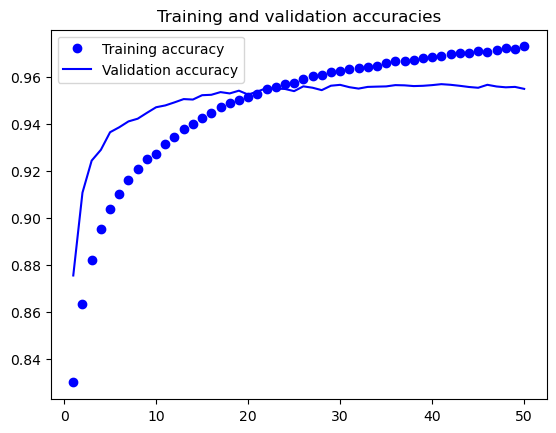

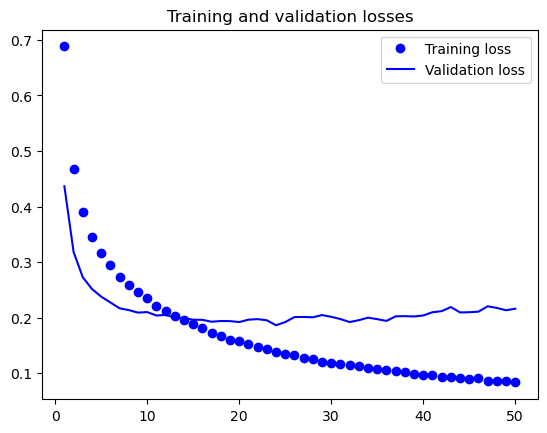

In [74]:
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracies')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation losses')
plt.legend()

plt.show()

In [75]:
model.eval()

Model(
  (embeddings): Embedding(
    (input_embedding): Embedding(402597, 100)
    (pos_embedding): Embedding(500, 100)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
    )
    (linear1): Linear(in_features=100, out_features=128, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (linear2): Linear(in_features=128, out_features=100, bias=True)
    (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.5, inplace=False)
    (dropout2): Dropout(p=0.5, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=

We try the model on a test sentence

In [76]:
sentence = 'Homer wrote the Iliad .'.lower().split()

We convert the sentence words to indices

In [77]:
# The indexes or the unknown word idx
sentence_word_idxs = torch.LongTensor([word2idx[word]
                                       if word in word2idx else 1
                                       for word in sentence])

The indices. Note the 1 at the end.

In [78]:
print('Sentence', sentence)
print('Sentence word indexes', sentence_word_idxs)

Sentence ['homer', 'wrote', 'the', 'iliad', '.']
Sentence word indexes tensor([182779, 393044, 359698, 189110,    936])


We predict the tags

In [79]:
sent_tag_predictions = model(sentence_word_idxs)

In [80]:
sent_tag_predictions.size()

torch.Size([5, 10])

The estimated probabilities of the first tag

In [81]:
F.softmax(sent_tag_predictions[0], dim=-1)

tensor([3.4586e-09, 1.8077e-07, 3.8602e-06, 2.5294e-06, 7.8201e-06, 2.7157e-08,
        3.7165e-06, 5.5435e-07, 3.4103e-07, 9.9998e-01],
       grad_fn=<SoftmaxBackward0>)

In [82]:
torch.argmax(F.softmax(sent_tag_predictions, dim=-1), dim=-1)

tensor([9, 9, 9, 3, 9])

We apply argmax to select the tag

In [83]:
for word_nbr, tag_predictions in enumerate(sent_tag_predictions):
    if int(sentence_word_idxs[word_nbr]) in idx2word:
        print(idx2word[int(sentence_word_idxs[word_nbr])], end=': ')
    else:
        print(sentence[word_nbr], '/ukn', end=': ')
    print(idx2ner.get(int(torch.argmax(F.softmax(tag_predictions, dim=-1), dim=-1))))

homer: O
wrote: O
the: O
iliad: B-ORG
.: O


## Evaluating the Model

In [84]:
test_sentences = read_sentences(test_file)
test_dict = split_rows(test_sentences, column_names)
test_dict[1:2]

[[{'FORM': 'SOCCER', 'PPOS': 'NN', 'PCHUNK': 'B-NP', 'NER': 'O'},
  {'FORM': '-', 'PPOS': ':', 'PCHUNK': 'O', 'NER': 'O'},
  {'FORM': 'JAPAN', 'PPOS': 'NNP', 'PCHUNK': 'B-NP', 'NER': 'B-LOC'},
  {'FORM': 'GET', 'PPOS': 'VB', 'PCHUNK': 'B-VP', 'NER': 'O'},
  {'FORM': 'LUCKY', 'PPOS': 'NNP', 'PCHUNK': 'B-NP', 'NER': 'O'},
  {'FORM': 'WIN', 'PPOS': 'NNP', 'PCHUNK': 'I-NP', 'NER': 'O'},
  {'FORM': ',', 'PPOS': ',', 'PCHUNK': 'O', 'NER': 'O'},
  {'FORM': 'CHINA', 'PPOS': 'NNP', 'PCHUNK': 'B-NP', 'NER': 'B-PER'},
  {'FORM': 'IN', 'PPOS': 'IN', 'PCHUNK': 'B-PP', 'NER': 'O'},
  {'FORM': 'SURPRISE', 'PPOS': 'DT', 'PCHUNK': 'B-NP', 'NER': 'O'},
  {'FORM': 'DEFEAT', 'PPOS': 'NN', 'PCHUNK': 'I-NP', 'NER': 'O'},
  {'FORM': '.', 'PPOS': '.', 'PCHUNK': 'O', 'NER': 'O'}]]

We predict the NER tags

In [85]:
test_loss, test_acc = evaluate(model, loss_fn, test_dataloader)
test_loss, test_acc

(0.2905119061470032, 0.9412420392036438)

We now predict the whole test set and we store the results in each dictionary with the key `pner`

In [86]:
test_sentences[0]

'-DOCSTART- -X- -X- O'

In [87]:
Y_test_pred = batch_inference(model, test_dataloader)

In [88]:
Y_test

tensor([[9, 0, 0,  ..., 0, 0, 0],
        [9, 9, 1,  ..., 0, 0, 0],
        [4, 8, 0,  ..., 0, 0, 0],
        ...,
        [4, 9, 1,  ..., 0, 0, 0],
        [9, 9, 1,  ..., 0, 0, 0],
        [9, 9, 9,  ..., 0, 0, 0]])

In [89]:
Y_test_pred_ner = torch.argmax(Y_test_pred, dim=-1)
Y_test_pred_ner

tensor([[9, 9, 9,  ..., 9, 9, 9],
        [9, 9, 1,  ..., 9, 9, 9],
        [8, 8, 7,  ..., 7, 7, 7],
        ...,
        [3, 9, 1,  ..., 9, 9, 9],
        [9, 9, 1,  ..., 9, 9, 9],
        [9, 9, 9,  ..., 9, 9, 9]])

In [90]:
for sent, y_hat_probs in zip(test_dict, Y_test_pred):
    sent_len = len(sent)
    y_hat_probs = y_hat_probs[:sent_len]
    # y_hat = torch.argmax(y_hat_probs, dim=-1) # This statement sometimes predicts 0 (the padding symbol)
    y_hat = torch.argmax(y_hat_probs[:, 1:], dim=-1) + 1  # Never predicts 0
    for word, ner_hat in zip(sent, y_hat):
        word['PNER'] = idx2ner.get(int(ner_hat))
        if word['PNER'] == None:
            print(sent)

A sentence example: `NER` is the hand annotation and `PNER` is the prediction.

In [91]:
test_dict[0]

[{'FORM': '-DOCSTART-',
  'PPOS': '-X-',
  'PCHUNK': '-X-',
  'NER': 'O',
  'PNER': 'O'}]

In [92]:
test_dict[1]

[{'FORM': 'SOCCER', 'PPOS': 'NN', 'PCHUNK': 'B-NP', 'NER': 'O', 'PNER': 'O'},
 {'FORM': '-', 'PPOS': ':', 'PCHUNK': 'O', 'NER': 'O', 'PNER': 'O'},
 {'FORM': 'JAPAN',
  'PPOS': 'NNP',
  'PCHUNK': 'B-NP',
  'NER': 'B-LOC',
  'PNER': 'B-LOC'},
 {'FORM': 'GET', 'PPOS': 'VB', 'PCHUNK': 'B-VP', 'NER': 'O', 'PNER': 'O'},
 {'FORM': 'LUCKY', 'PPOS': 'NNP', 'PCHUNK': 'B-NP', 'NER': 'O', 'PNER': 'O'},
 {'FORM': 'WIN', 'PPOS': 'NNP', 'PCHUNK': 'I-NP', 'NER': 'O', 'PNER': 'O'},
 {'FORM': ',', 'PPOS': ',', 'PCHUNK': 'O', 'NER': 'O', 'PNER': 'O'},
 {'FORM': 'CHINA',
  'PPOS': 'NNP',
  'PCHUNK': 'B-NP',
  'NER': 'B-PER',
  'PNER': 'B-LOC'},
 {'FORM': 'IN', 'PPOS': 'IN', 'PCHUNK': 'B-PP', 'NER': 'O', 'PNER': 'O'},
 {'FORM': 'SURPRISE', 'PPOS': 'DT', 'PCHUNK': 'B-NP', 'NER': 'O', 'PNER': 'O'},
 {'FORM': 'DEFEAT', 'PPOS': 'NN', 'PCHUNK': 'I-NP', 'NER': 'O', 'PNER': 'O'},
 {'FORM': '.', 'PPOS': '.', 'PCHUNK': 'O', 'NER': 'O', 'PNER': 'O'}]

In [93]:
cnt = 0
cnt_corr = 0
for s in test_dict:
    for w in s:
        if w['PNER'] == w['NER']:
            cnt_corr += 1
        cnt += 1

In [94]:
cnt_corr/cnt

0.9412420177431107

We save the test set in a file to evaluate the performance of our model.

In [95]:
column_names = ['FORM', 'PPOS', 'PCHUNK', 'NER', 'PNER']

In [96]:
def save(file, corpus_dict, column_names):
    """
    Saves the corpus in a file
    :param file:
    :param corpus_dict:
    :param column_names:
    :return:
    """
    i = 0
    with open(file, 'w', encoding='utf8') as f_out:
        i += 1
        for sentence in corpus_dict:
            sentence_lst = []
            for row in sentence:
                items = map(lambda x: row.get(x, '_'), column_names)
                sentence_lst += ' '.join(items) + '\n'
            sentence_lst += '\n'
            f_out.write(''.join(sentence_lst))

In [97]:
outfile = 'test_model.out'

In [98]:
save(outfile, test_dict, column_names)

In [99]:
lines = open(outfile, encoding='utf8').read().splitlines()
res = conlleval.evaluate(lines)
chunker_score = res['overall']['chunks']['evals']['f1']
chunker_score

0.7043637574950034

In [100]:
config

{'EPOCHS': 50,
 'num_layers': 4,
 'DROPOUT': 0.5,
 'EMB_LARGE': True,
 'FREEZE_EMBS': False}

In [ ]:
torch.save(model.state_dict(), 'model.pth')